In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats

In [2]:
data_path = '../../data/temporal_unigram_cos_samplew/'

In [3]:
fandom_list_prev = [i for i in os.listdir(data_path) if 'prev' in i]

In [4]:
fandom_list_futu = [i for i in os.listdir(data_path) if 'futu' in i]

In [5]:
df_1 = pd.read_csv(os.path.join(data_path, fandom_list_prev[0]), sep = '\t')

In [6]:
len(df_1)

1200

In [7]:
df_2 = pd.read_csv(os.path.join(data_path, fandom_list_futu[0]), sep = '\t')

In [8]:
len(df_2)

1200

In [9]:
df = pd.merge(df_1, df_2, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks',
       'Category', 'ChapterIndex', 'Chapters', 'Characters', 'Comments',
       'CompleteDate', 'Fandoms', 'Hits', 'Kudos', 'Language', 'Notes',
       'PublishDate', 'Rating', 'Relationship', 'Summary', 'Title', 'URL',
       'UpdateDate', 'Words'], how='inner')

In [10]:
df = df.dropna(subset=['Cos_x', 'Cos_y', 'Kudos'])
x = abs(df['Cos_x'] - df['Cos_y'])
y = df['Kudos']
stats.pearsonr(x,y)


(-0.17144309451707987, 0.28381765143541215)

In [12]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [13]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
    df = df[df.Kudos != 0]
    df['Kudos'] = np.log(df['Kudos'])
    df = df[df.Hits != 0]
    df['Hits'] = np.log(df['Hits'])
#     df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)"

#     # turn into z scores
    df['Kudos'] = df['Kudos'].astype(float)
    df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)

    return df

### Plot with bins

In [14]:
def create_dict(fandom, field, binsize):
    
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t', error_bad_lines=False)
    df = df.dropna(subset = [field])
    df = create_normed_dfs(df)
    print(len(df))
    # Make bins
    df.Cos = df.Cos.astype(float)
    min_cos = min(df.Cos.tolist()) - 0.1
    max_cos = max(df.Cos.tolist()) + 0.1
    dic = {}
    for i in np.arange(min_cos, max_cos, binsize):
        df_s = df[(df.Cos >= i) & (df.Cos < i+binsize)]
        if len(df_s > 0):
            dic[i] = bootstrap_resample(df_s[field].tolist())
    return dic

In [20]:
def plot_scatter(fandom_list):
    fig, axs = plt.subplots(5,5, figsize=(30, 20))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i,fandom in enumerate(fandom_list):
        dic = create_dict(fandom, 'Kudos', 0.05)
        x = sorted(dic.keys())
        y = [dic[j][0] for j in x]

#     Make error bars
        lower_error = [dic[j][0]-dic[j][1] for j in x]
        upper_error = [dic[j][2]-dic[j][0] for j in x]
        asymmetric_error = [lower_error, upper_error]

        axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
#         title = fandom.replace('_temporal_cos_toprev.tsv', '').replace('all_media_types', '')\
#         .replace("&_related_fandoms", '').replace("_", ' ').capitalize().replace('Dcu', 'DCU')
        title = fandom[0:20]
        axs[i].set_title(title, fontsize = 20)
#         axs[i].set_xlim([min(x) -1, max(x) + 1])
#         axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)

#         break
        # ax.set_yscale('log')

        fig.text(0.5, 0.06, 'Cosine distance', ha='center', va='center', fontsize=25)
        fig.text(0.08, 0.5, 'Log Kudos', ha='center', va='center', rotation='vertical',fontsize=25)

#     plt.savefig('cos_log_kudos_toprev.pdf', format = 'pdf')



In [16]:
def plot_scatter(fandom_list):
    fig, axs = plt.subplots(5,5, figsize=(30, 20))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t', error_bad_lines=False)
        axs[i].scatter(df['Cos'], np.log(df['Kudos']))
        title = fandom[0:20]
        axs[i].set_title(title, fontsize = 20)
#     plt.savefig('cos_log_kudos_toprev.pdf', format = 'pdf')



1185
498
763
1152
1183
1161
1185
400
100
1173
1182
1095
795
695
1193
1090
1177
689
679
1191
1154
1180
893
794
1135


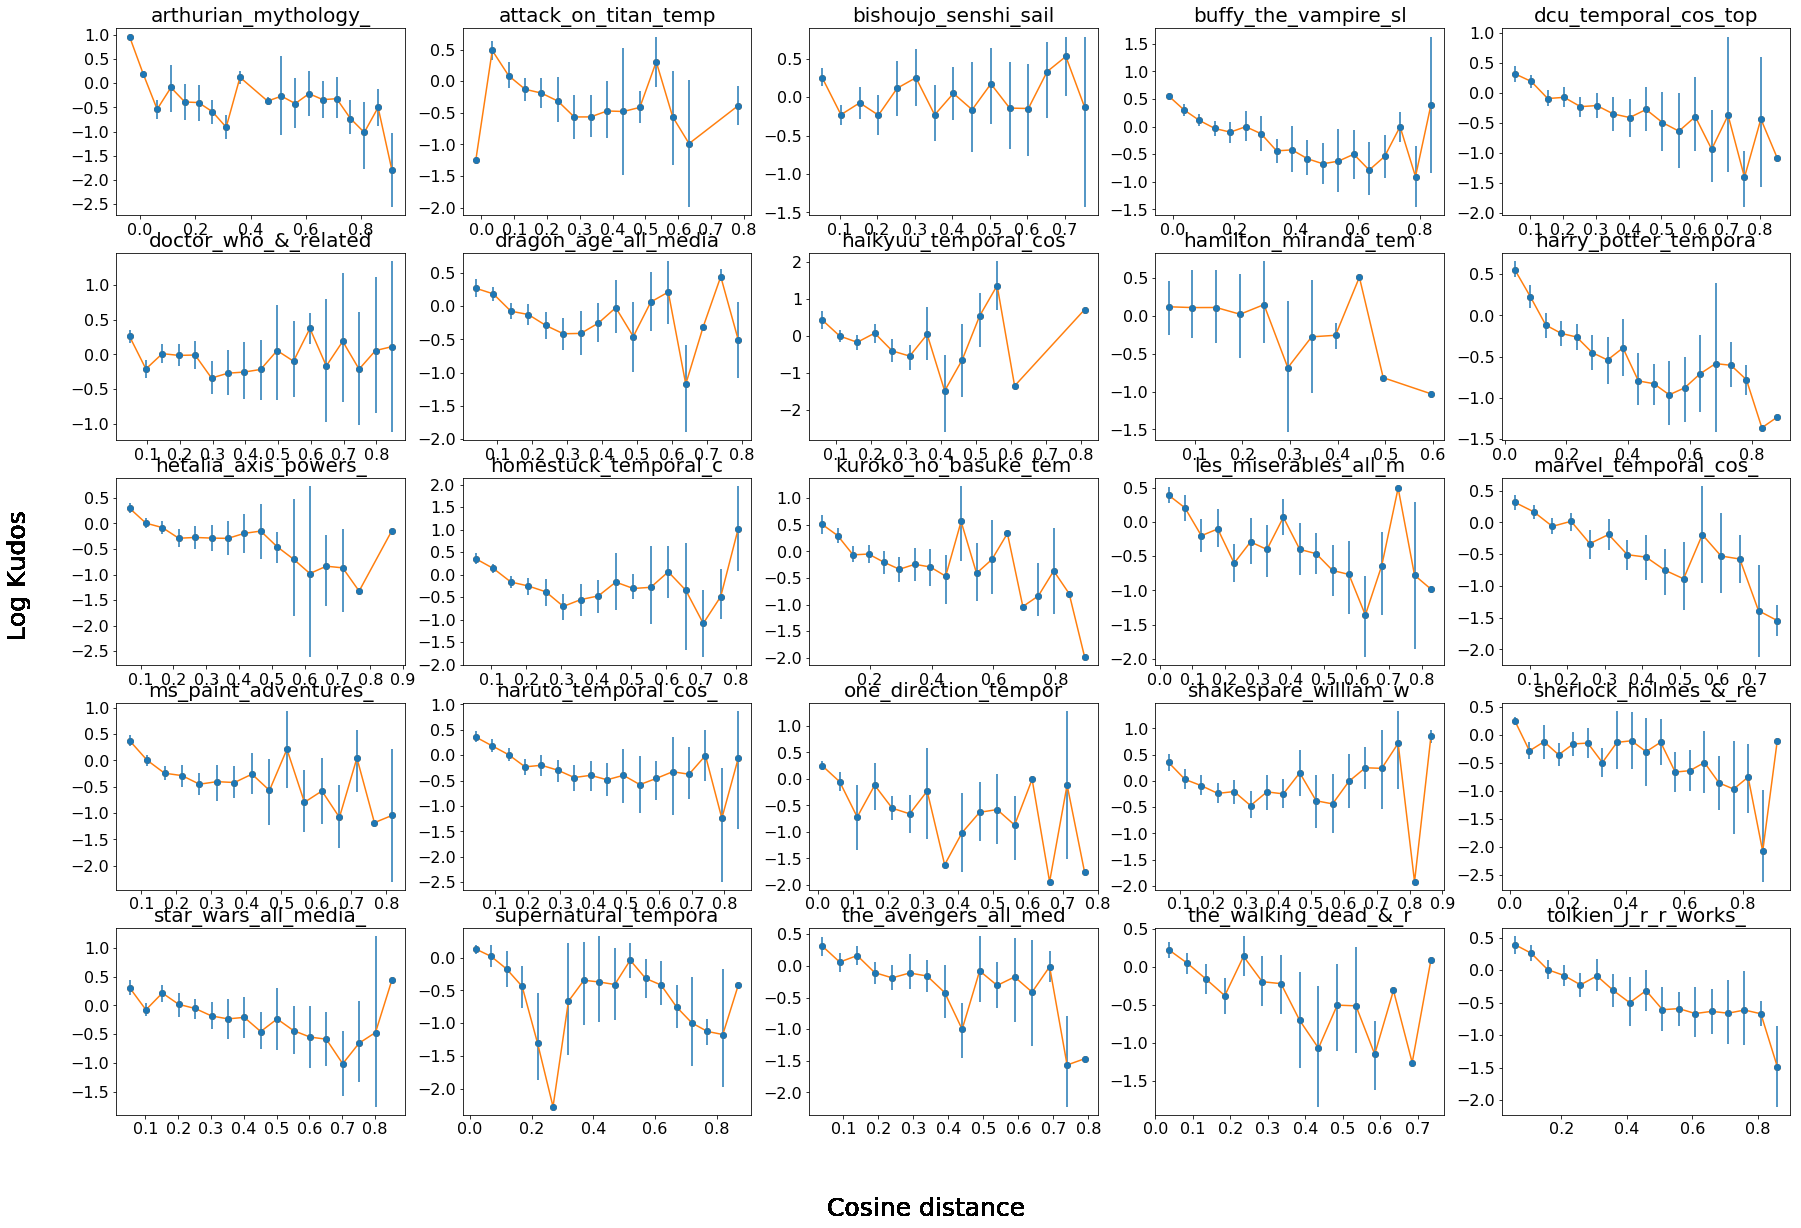

In [21]:
plot_scatter(fandom_list_prev)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/cbook.py:2066: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/cbook.py:2081: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/cbook.py:2082: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


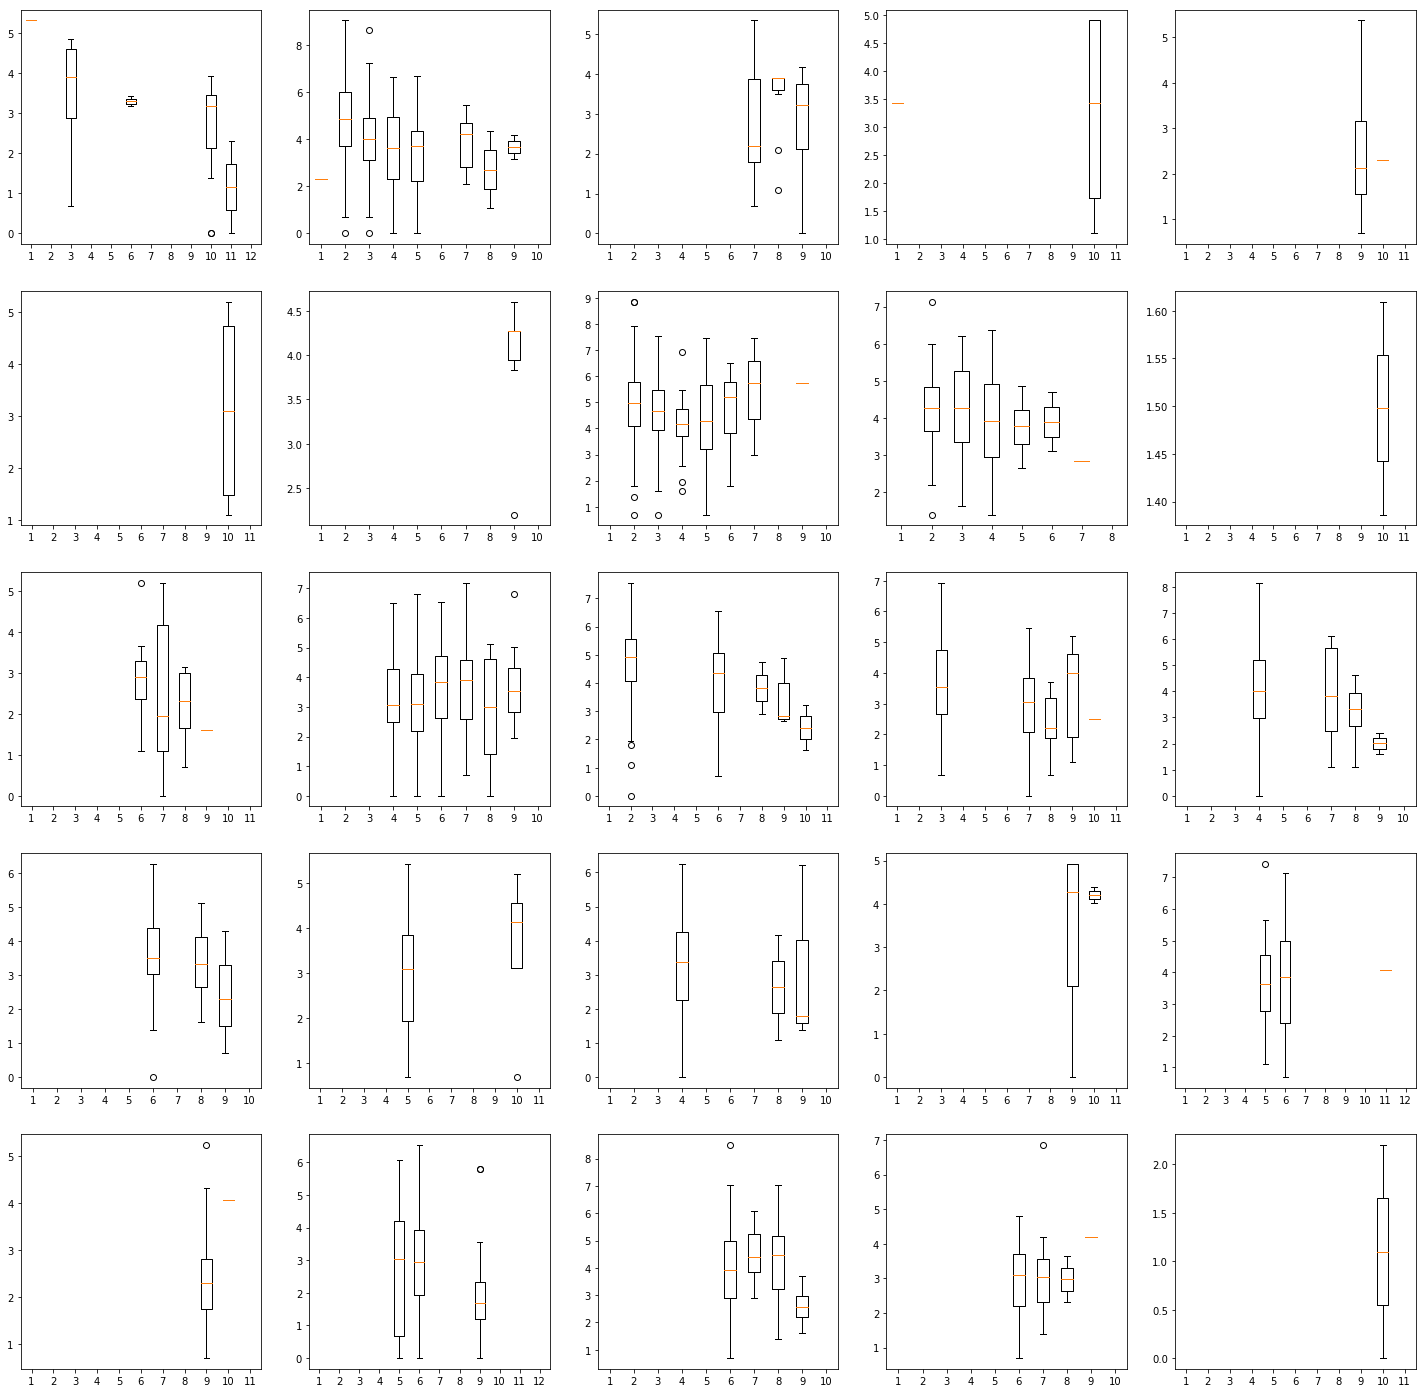

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.ravel()

for idx, fandom in enumerate(fandom_list_prev):
    df = pd.read_csv(data_path + fandom, sep = '\t')
    df['Kudos'] = np.log(df['Kudos'])
#     df = df[['']]

#     df.tag_novelty = df.tag_novelty * 1000
    min_n = min(df.Cos.tolist()) - 0.1
    max_n = max(df.Cos.tolist()) + 0.1
    x = []
    for i in np.arange(min_n, max_n, 0.1):
        df_s = df[(df.Cos >= i) & (df.Cos < i+0.1)]
        x.append(df_s.Kudos.tolist())    
    axs[idx].boxplot(x)

#     axs[idx].set_title(fandom.replace('.pkl', ''), fontsize=25)
# fig.text(0.5, 0.1,'Time', ha='center', va='center', fontsize=25)
# fig.text(0.08, 0.5, 'Cosine distance', ha='center', va='center', rotation='vertical',fontsize=25)

# plt.savefig('temporal_cos_dist_box.png', format='png')
    

## Aggregate

In [31]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
#     df = df[df.Kudos != 0]
#     df['Kudos'] = np.log(df['Kudos'])
#     df = df[df.Hits != 0]
#     df['Hits'] = np.log(df['Hits'])
#     df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)"

#     # turn into z scores
    df['Kudos'] = df['Kudos']/df['Chapters']
    df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)

    return df

In [32]:
def create_dict(df, field, binsize):
    
    # Make bins
    df.Cos = df.Cos.astype(float)
    min_cos = min(df.Cos.tolist())
    max_cos = max(df.Cos.tolist())
    dic = {}
    for i in np.arange(min_cos, max_cos, binsize):
        df_s = df[(df.Cos >= i) & (df.Cos < i+binsize)]
#         if len(df_s) > 9:
#             print (min_cos, max_cos)
#             print(df_s[field].tolist())
        li = df_s[field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

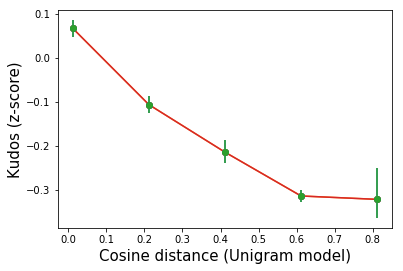

In [37]:
df_all = []
for i,fandom in enumerate(fandom_list_prev):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t', error_bad_lines=False)
    df = create_normed_dfs(df)
    df = df[['Cos', 'Kudos']].dropna()
    df_all.append(df)

df = pd.concat(df_all)

dic = create_dict(df, 'Kudos', 0.2)
x = sorted(dic.keys())
y = [dic[j][0] for j in x]

#     Make error bars
lower_error = [dic[j][0]-dic[j][1] for j in x]
upper_error = [dic[j][2]-dic[j][0] for j in x]
asymmetric_error = [lower_error, upper_error]



plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
plt.plot(x, y, 'o-')
plt.xlabel('Cosine distance (Unigram model)',fontsize=15)
plt.ylabel('Kudos (z-score)',fontsize=15)

plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
plt.plot(x, y, 'o-')
# #         title = fandom.replace('_temporal_cos_toprev.tsv', '').replace('all_media_types', '')\
# #         .replace("&_related_fandoms", '').replace("_", ' ').capitalize().replace('Dcu', 'DCU')
# #         axs[i].set_title(title, fontsize = 20)
# #         axs[i].set_xlim([min(x) -1, max(x) + 1])
# #         axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
#     for tick in axs[i].xaxis.get_major_ticks():
#         tick.label.set_fontsize(16) 
#     for tick in axs[i].yaxis.get_major_ticks():
#         tick.label.set_fontsize(16)

# #         break
#     # ax.set_yscale('log')

#     fig.text(0.5, 0.06, 'Cosine distance', ha='center', va='center', fontsize=25)
#     fig.text(0.08, 0.5, 'Log Kudos', ha='center', va='center', rotation='vertical',fontsize=25)

# #         except:
# #             pass
plt.savefig('unigram_cos_kudos_z_toprev_samplew.pdf', format = 'pdf')

